In [1]:
# === Safe setup: packages + paths ===
from pathlib import Path
import sys, subprocess, importlib.util, platform

print("OS:", platform.platform())

BASE = Path(r"C:\Users\lynn400\Projects\data-visualization-labs")   # 本機 repo 根目錄
PROJ = BASE / "self-extended-practice" / "semiconductor-tariff-impact-taiwan"
DATA = PROJ / "data"
print("BASE exists?", BASE.exists())
print("DATA exists?", DATA.exists())

def ensure(pkgs):
    missing = [p for p in pkgs if importlib.util.find_spec(p) is None]
    if missing:
        print("Installing:", missing)
        subprocess.check_call([sys.executable, "-m", "pip", "install",
                               "--quiet", "--disable-pip-version-check", *missing])
    else:
        print("All good:", pkgs)

# 缺才裝（秒過）
ensure(["pandas", "matplotlib", "statsmodels", "linearmodels"])

# 目錄快速自檢
for p in [DATA, DATA/"processed", DATA/"raw"]:
    print("\n==", p, "==")
    if p.exists():
        for i, f in enumerate(sorted(p.glob("*"))[:30], 1):
            print(f"{i:>2}.", f.name)


OS: Windows-10-10.0.19045-SP0
BASE exists? True
DATA exists? True
All good: ['pandas', 'matplotlib', 'statsmodels', 'linearmodels']

== C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\data ==
 1. ai_demand_index_2015_2025.csv
 2. external
 3. mappings
 4. metadata
 5. processed
 6. raw

== C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\data\processed ==
 1. event_impact_summary.csv
 2. ic_exports_comparison.csv
 3. ic_with_ai_index.csv
 4. top10_export_markets_avg_2013_2025.csv
 5. top10_export_markets_trend_2013_2025.csv
 6. us_tariffs_with_policy_events.csv

== C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\data\raw ==
 1. ic_exports_comparison_uncomtrade_2013_2024.csv
 2. ic_exports_world_HS8542_202501_202508_uncomtrade.csv
 3. ic_exports_world_HS8542_raw.csv
 4. taiwan_exports_8542_2013_2025.csv
 5. tai

In [2]:
# === Load IC exports (prefer processed standard file) ===
from pathlib import Path
import pandas as pd

primary = DATA / "processed" / "ic_exports_comparison.csv"
alts = [
    DATA / "processed" / "ic_exports_comparison_uncomtrade_2013_2024.csv",
    DATA / "processed" / "ic_exports_comparison_2013_2024.csv",
]

path = primary if primary.exists() else next((p for p in alts if p.exists()), None)
if path is None:
    cands = sorted([p for p in PROJ.rglob("*ic_exports*.*") if p.is_file()])
    print(f"找到 {len(cands)} 個候選：")
    for i, p in enumerate(cands[:10], 1):
        print(f"{i:>2}.", p)
    path = cands[0] if cands else None

assert path and path.exists(), "找不到 ic_exports 檔案，請確認 processed 目錄。"
print("✅ 使用檔案：", path)

df_ic = pd.read_excel(path) if path.suffix.lower() in (".xlsx", ".xls") else pd.read_csv(path, encoding="utf-8-sig")
print("IC 資料筆數：", len(df_ic), "；前幾欄：", list(df_ic.columns)[:8])


✅ 使用檔案： C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\data\processed\ic_exports_comparison.csv
IC 資料筆數： 48 ；前幾欄： ['typecode', 'freqcode', 'refperiodid', 'refyear', 'refmonth', 'period', 'reportercode', 'reporteriso']


In [3]:
# === Build/Load AI demand index (prefer local CSV) ===
import pandas as pd, sys, subprocess
from pathlib import Path

ai_idx_path = DATA / "ai_demand_index_2015_2025.csv"
if ai_idx_path.exists():
    monthly = pd.read_csv(ai_idx_path)
    print("✅ Loaded existing:", ai_idx_path, "rows =", len(monthly))
else:
    # 只有真的沒有檔案才抓 pytrends（需連網，可能較慢）
    def ensure(pkg):
        try: __import__(pkg)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    ensure("pytrends")
    from pytrends.request import TrendReq

    KW_LIST   = ["Artificial Intelligence", "Machine Learning", "Generative AI"]
    TIMEFRAME = "2015-01-01 2025-12-31"
    GEO       = ""     # 全球

    pytrends = TrendReq(hl="en-US", tz=360)
    pytrends.build_payload(KW_LIST, timeframe=TIMEFRAME, geo=GEO)
    weekly = pytrends.interest_over_time().reset_index()
    if "isPartial" in weekly.columns:
        weekly = weekly.drop(columns=["isPartial"])

    # 週→月 + MinMax + 均值合成一條指數
    weekly["date"] = pd.to_datetime(weekly["date"])
    monthly = weekly.set_index("date").resample("MS").mean().reset_index()
    for c in KW_LIST:
        s = monthly[c].astype(float)
        mn, mx = s.min(), s.max()
        monthly[c] = (s - mn)/(mx - mn)*100 if mx > mn else 0.0
    monthly["ai_demand_index"] = monthly[KW_LIST].mean(axis=1)
    monthly["ym"] = monthly["date"].dt.strftime("%Y-%m")
    monthly.to_csv(ai_idx_path, index=False, encoding="utf-8-sig")
    print("✅ Saved:", ai_idx_path)


✅ Loaded existing: C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\data\ai_demand_index_2015_2025.csv rows = 129


IC 季資料：36 筆，2013–2024
   year  quarter      fobvalue
0  2013        1  8.788078e+10
1  2013        2  4.711805e+10
2  2013        3  3.454451e+10
3  2014        1  6.121333e+10
4  2014        2  5.154387e+10
AI 季資料：43 筆，2015–2025
   year  quarter  ai_demand_index
0  2015        1         0.389099
1  2015        2         0.628047
2  2015        3         0.778198
3  2015        4         1.495043
4  2016        1         2.184443
合併樣本數： 30

=== OLS (raw) ===
                            OLS Regression Results                            
Dep. Variable:               fobvalue   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     6.052
Date:                Tue, 23 Sep 2025   Prob (F-statistic):             0.0203
Time:                        17:14:20   Log-Likelihood:                -770.53
No. Observations:                  30   AIC:                   

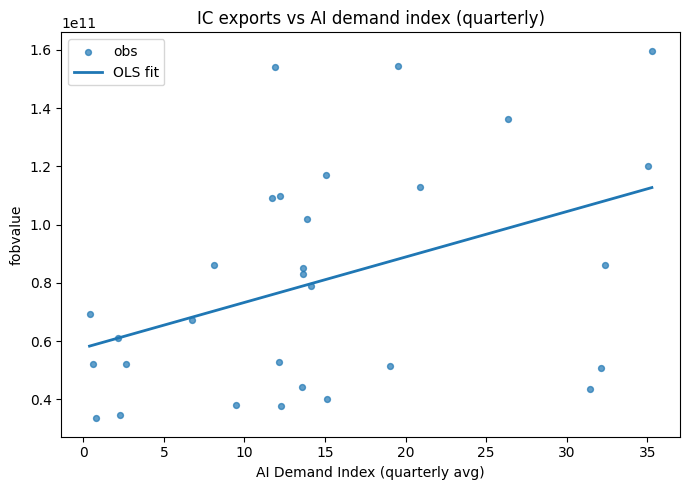

✅ 已存圖： C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\output\ai\ic_vs_ai_quarterly.png
✅ 已輸出合併檔： C:\Users\lynn400\Projects\data-visualization-labs\self-extended-practice\semiconductor-tariff-impact-taiwan\data\processed\ic_with_ai_index.csv


In [4]:
# === Cell 4：IC×AI 合併（到季）+ 回歸 + 畫圖 + 輸出 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path

# 基本檢查：前面三格要先跑過
assert all(k in globals() for k in ["PROJ", "DATA", "df_ic", "monthly"]), "請先執行 Cell 1–3"

OUT = PROJ / "output" / "ai"
OUT.mkdir(parents=True, exist_ok=True)

# ---------- 1) 準備 IC：偵測年份、指派季別、挑選金額欄 ----------
ic = df_ic.copy()

def _num(s):
    return pd.to_numeric(s, errors="coerce")

# 偵測「年」欄位（誰像 2000–2035 的比例高就用誰）
ycands = []
for c in ["refperiodid", "refyear", "period"]:
    if c in ic.columns:
        v = _num(ic[c])
        ycands.append((c, float(v.between(2000, 2035).mean())))
ycands.sort(key=lambda x: x[1], reverse=True)
if ycands and ycands[0][1] >= 0.5:
    year_col = ycands[0][0]
elif "refyear" in ic.columns:
    year_col = "refyear"
else:
    # 最後退路：找一個數值比例高的欄位當年（不建議，但保底）
    num_cols = [c for c in ic.columns if _num(ic[c]).notna().mean() > 0.8]
    assert num_cols, "偵測不到年份欄位，請檢查 IC 檔內容。"
    year_col = num_cols[0]

ic["year"] = _num(ic[year_col]).round().astype("Int64")
ic = ic[ic["year"].notna()].copy()
ic["year"] = ic["year"].astype(int)

# 年內排序鍵（優先 refmonth，其次 period，否則原始順序）
sk = None
for c in ["refmonth", "period"]:
    if c in ic.columns:
        v = _num(ic[c])
        if v.notna().any():
            sk = v
            break
if sk is None:
    sk = np.arange(len(ic))

ic = ic.assign(_sk=sk).sort_values(["year", "_sk"], na_position="last").copy()
# 指派季別 Q1..Q4（就算每年不足 4 筆也能循環）
ic["quarter"] = (ic.groupby("year").cumcount() % 4) + 1

# 目標欄位：FOB > CIF > 其它連續欄
ban = {"typecode","freqcode","refperiodid","refyear","refmonth","reportercode","reporteriso",
       "partnercode","partneriso","partnerdesc","period","_sk","year","quarter","ym","yq"}
if "fobvalue" in ic.columns:
    target_col = "fobvalue"
elif "cifvalue" in ic.columns:
    target_col = "cifvalue"
else:
    num_cands = [c for c in ic.columns if c not in ban and _num(ic[c]).notna().sum() >= 6]
    assert num_cands, "沒有找到可用的金額欄位（fobvalue/cifvalue/其他連續欄）。"
    target_col = num_cands[0]

ic[target_col] = _num(ic[target_col])
icq = ic.groupby(["year","quarter"], as_index=False)[target_col].sum().dropna(subset=[target_col])
print(f"IC 季資料：{len(icq)} 筆，{icq['year'].min()}–{icq['year'].max()}")
print(icq.head())

# ---------- 2) 準備 AI：月 → 季平均（強制轉成 datetime） ----------
ai_m = monthly.copy()

# 讓 ai_m["date"] 一定是 datetime
if "date" in ai_m.columns:
    ai_m["date"] = pd.to_datetime(ai_m["date"], errors="coerce")
elif "ym" in ai_m.columns:
    ai_m["date"] = pd.to_datetime(ai_m["ym"].astype(str).str.strip() + "-01", errors="coerce")
else:
    raise ValueError("AI 指數檔缺少 'date' 或 'ym' 欄位，請檢查 ai_demand_index_2015_2025.csv")

ai_m = ai_m.dropna(subset=["date"]).copy()
ai_m["year"] = ai_m["date"].dt.year.astype(int)
ai_m["quarter"] = ai_m["date"].dt.quarter.astype(int)

aiq = ai_m.groupby(["year","quarter"], as_index=False)["ai_demand_index"].mean()
print(f"AI 季資料：{len(aiq)} 筆，{aiq['year'].min()}–{aiq['year'].max()}")
print(aiq.head())

# ---------- 3) 合併 ----------
merged = icq.merge(aiq, on=["year","quarter"], how="inner")
print("合併樣本數：", len(merged))
assert len(merged) > 0, "合併為 0，請確認 IC 年份是否和 AI（2015 起）有重疊。"

# ---------- 4) OLS（raw + log1p） ----------
m_raw = smf.ols(f"{target_col} ~ ai_demand_index", data=merged).fit()
print("\n=== OLS (raw) ===")
print(m_raw.summary())

merged["y_log"] = np.log1p(merged[target_col])
m_log = smf.ols("y_log ~ ai_demand_index", data=merged).fit()
print("\n=== OLS (log1p) ===")
print(m_log.summary())

# ---------- 5) 畫圖並存檔 ----------
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(merged["ai_demand_index"], merged[target_col], s=18, alpha=0.7, label="obs")
xs = np.linspace(merged["ai_demand_index"].min(), merged["ai_demand_index"].max(), 100)
ys = m_raw.params["Intercept"] + m_raw.params["ai_demand_index"] * xs
ax.plot(xs, ys, linewidth=2, label="OLS fit")
ax.set_xlabel("AI Demand Index (quarterly avg)")
ax.set_ylabel(target_col)
ax.set_title("IC exports vs AI demand index (quarterly)")
ax.legend()
fig.tight_layout()

png_path = OUT / "ic_vs_ai_quarterly.png"
fig.savefig(png_path, dpi=150)
plt.show()
print("✅ 已存圖：", png_path)

# ---------- 6) 輸出合併表 ----------
csv_out = DATA / "processed" / "ic_with_ai_index.csv"
merged.to_csv(csv_out, index=False, encoding="utf-8-sig")
print("✅ 已輸出合併檔：", csv_out)


In [5]:
# === Fixed-effects (year + quarter) with HAC robust SE ===
import statsmodels.formula.api as smf

m_fe = smf.ols("y_log ~ ai_demand_index + C(year) + C(quarter)", data=merged).fit()
m_hac = m_fe.get_robustcov_results(cov_type="HAC", maxlags=1)
print(m_hac.summary())


                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     57.74
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           2.42e-11
Time:                        17:14:21   Log-Likelihood:                 20.556
No. Observations:                  30   AIC:                            -15.11
Df Residuals:                      17   BIC:                             3.103
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.9926      0.059    4